In [1]:
import pandas as pd
import numpy as np
import numpy as np
import re
import seaborn as sns
from scipy import stats
import math
import operator
import plotly
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, plot
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 10
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import feather

In [229]:
### Cargar dataset "limpio"
df = feather.read_dataframe("Data/principal.feather")
df.sample(1)

property_type                        lat-lon        lat        lon  \
1362              1  -34.4270693435,-58.5670843041 -34.427069 -58.567084   

          price  price_aprox_usd  surface_total_in_m2  surface_covered_in_m2  \
1362  7485241.0        419799.83                163.0                  105.0   

      price_usd_per_m2  price_per_m2  ambientes  provincia  partido  \
1362        2575.45908   3145.870372        4.0        0.0      8.0   

      localidad  condicion price_aprox_usd_levels  geonames_id  
1362      232.0        NaN                      5    3427753.0

In [230]:
to_drop = [
            'price_usd_per_m2', 
            'price_per_m2', 
            'price',
#             'localidad',
            'condicion'
] 
df.drop(columns=to_drop, inplace=True) #aplicar drop
df.sample(1)

property_type              lat-lon       lat       lon  \
40725              3  -34.49397,-58.51679 -34.49397 -58.51679   

       price_aprox_usd  surface_total_in_m2  surface_covered_in_m2  ambientes  \
40725         380000.0                308.0                  217.0        NaN   

       provincia  partido  localidad price_aprox_usd_levels  geonames_id  
40725        0.0      6.0      174.0                      5    3430813.0

In [231]:
df.isnull().sum()

property_type                 0
lat-lon                       0
lat                        8346
lon                        8346
price_aprox_usd           23831
surface_total_in_m2        9687
surface_covered_in_m2     11755
ambientes                 30280
provincia                     0
partido                    1904
localidad                 68992
price_aprox_usd_levels    23831
geonames_id                  97
dtype: int64

In [232]:
# Creamos nueva variable de superficie por cada ambiente
# vamos probando  el efecto entre varias combinaciones
df['surface_by_amb'] = df.surface_total_in_m2/df.ambientes
df['surface_by_add'] = df.surface_total_in_m2+df.surface_covered_in_m2
df['surface_covered_prop'] = df.surface_covered_in_m2/df.surface_total_in_m2
df['surface_total_prop_cov'] = df.surface_total_in_m2/df.surface_covered_in_m2
df['surface_cov_complete'] = df.surface_covered_in_m2.fillna(df.surface_total_in_m2)
df['new_rel1'] = (df.surface_total_in_m2+df.surface_covered_in_m2)+df.ambientes
df['new_rel2'] = df.surface_cov_complete+df.surface_total_prop_cov
df['new_rel3'] = (df.surface_cov_complete+df.surface_total_prop_cov)/df.ambientes
df['new_rel4'] = (df.surface_cov_complete/df.ambientes)
df['new_rel5'] = (df.surface_cov_complete+df.surface_total_prop_cov/df.ambientes)
df['new_rel6'] = ((df.surface_cov_complete/df.ambientes)+df.surface_total_prop_cov)
df.sample(1)

property_type           lat-lon    lat       lon  price_aprox_usd  \
86164              1  -34.62,-58.37122 -34.62 -58.37122        131553.57   

       surface_total_in_m2  surface_covered_in_m2  ambientes  provincia  \
86164                 37.0                   33.0        2.0        5.0   

       partido    ...      surface_by_add surface_covered_prop  \
86164    168.0    ...                70.0             0.891892   

       surface_total_prop_cov  surface_cov_complete  new_rel1   new_rel2  \
86164                1.121212                  33.0      72.0  34.121212   

        new_rel3  new_rel4   new_rel5   new_rel6  
86164  17.060606      16.5  33.560606  17.621212  

[1 rows x 24 columns]

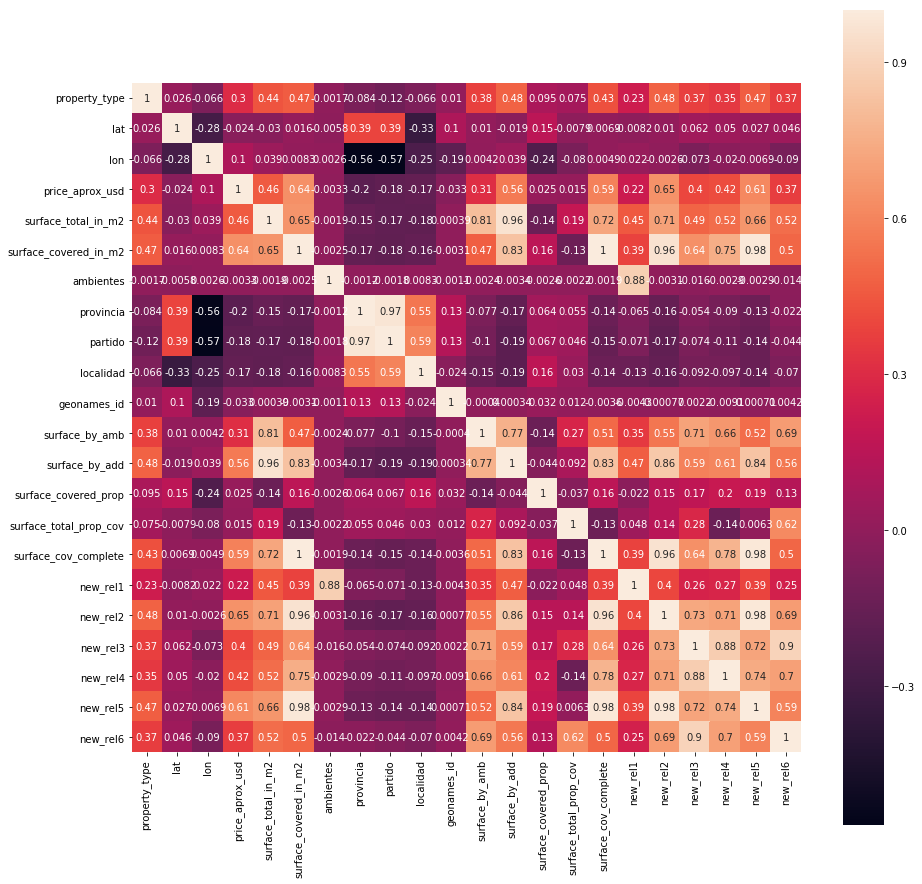

In [233]:
# Matriz de correlacion
fig, ax = plt.subplots(figsize=(15,15))       
sns.heatmap(df.corr() , square=True, annot=True, ax=ax);

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning:

invalid value encountered in reduce

/opt/conda/lib/python3.6/site-packages/numpy/linalg/linalg.py:1876: RuntimeWarning:

invalid value encountered in greater



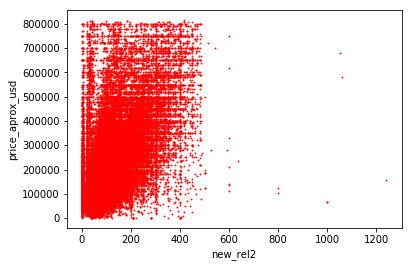

In [181]:
#reviso relación entre new_rel2 y price_aprox_usd
sns.regplot(df.new_rel2,df.price_aprox_usd, order=1, ci=None, scatter_kws={'color':'r', 's':1})
# ಠ ʖ̯ ͡ಠ

In [276]:
df = df_bak.copy()
# df_bak = df.copy()
df.sample(1)

property_type                        lat-lon        lat        lon  \
33344              1  -34.560428,-58.46101899999999 -34.560428 -58.461019   

       price_aprox_usd  surface_total_in_m2  surface_covered_in_m2  ambientes  \
33344         248000.0                120.0                  100.0        4.0   

       provincia  partido    ...     surface_by_add surface_covered_prop  \
33344        5.0    134.0    ...              220.0             0.833333   

       surface_total_prop_cov  surface_cov_complete  new_rel1  new_rel2  \
33344                     1.2                 100.0     224.0     101.2   

       new_rel3  new_rel4  new_rel5  new_rel6  
33344      25.3      25.0     100.3      26.2  

[1 rows x 24 columns]

In [277]:
#  Rompo todas las columnas porque no puedo graficar sns.pairplot 
# ◔̯◔
to_drop = [
            'new_rel1', 
            'new_rel3', 
            'new_rel4', 
            'new_rel6', 
            'geonames_id', 
            'lat-lon',
            'surface_covered_in_m2',
            'lat','lon',
            'surface_by_amb',
            'surface_by_add',
            'surface_covered_prop',
            'surface_total_prop_cov',
            'surface_cov_complete',
            'price_aprox_usd_levels',
            'ambientes',
            'property_type',
] 
df.drop(columns=to_drop, inplace=True) #aplicar drop
df.sample(1)

price_aprox_usd  surface_total_in_m2  provincia  partido  localidad  \
6990              NaN            68.252712        1.0     18.0      308.0   

       new_rel2   new_rel5  
6990  51.365054  50.455018

In [278]:
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["new_rel2","new_rel5"], how="all")
df.describe()

price_aprox_usd  surface_total_in_m2      provincia        partido  \
count     87551.000000        105449.000000  105449.000000  104145.000000   
mean     192571.925405           144.785233       5.440298     128.490873   
std      146273.535667           184.320307       6.712574     145.652471   
min           0.000000             0.000000       0.000000       0.000000   
25%       90000.000000            45.000000       1.000000      14.000000   
50%      140000.000000            76.000000       4.000000      67.000000   
75%      250000.000000           175.821128       5.000000     168.000000   
max      815000.000000          1490.000000      27.000000     538.000000   

          localidad       new_rel2      new_rel5  
count  45652.000000  105449.000000  85076.000000  
mean     282.942894     101.652639     95.408105  
std      121.524086      90.005078     86.410899  
min        0.000000       1.000000     -3.555556  
25%      220.000000      42.219512     40.500000  
50%      257.000000      68.089552     65.333333  
75%      395.000000     133.363636    124.422754  
max      567.000000    1362.000000   1362.000000

In [279]:
#  Rompo todas las columnas 
# 
columnas_principales = ['price_aprox_usd','surface_total_in_m2','partido','new_rel2','new_rel5']
df = df.dropna(axis =0 , how = 'any', subset = columnas_principales)
df.shape

(70819, 7)

In [280]:
# elimino columna localidad porque no la voy a utilizar
df.drop(columns=['localidad'], inplace=True) #aplicar drop
# elimino todos los que tengan nulos dado los fill infinites de new_rel2 y new_rel5
df = df.dropna(axis=0 , how = 'any')
df.shape
df.sample(1)

price_aprox_usd  surface_total_in_m2  provincia  partido   new_rel2  \
34179          80000.0                200.0        1.0     18.0  49.444444   

        new_rel5  
34179  46.481481

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning:

invalid value encountered in greater_equal

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning:

invalid value encountered in less_equal



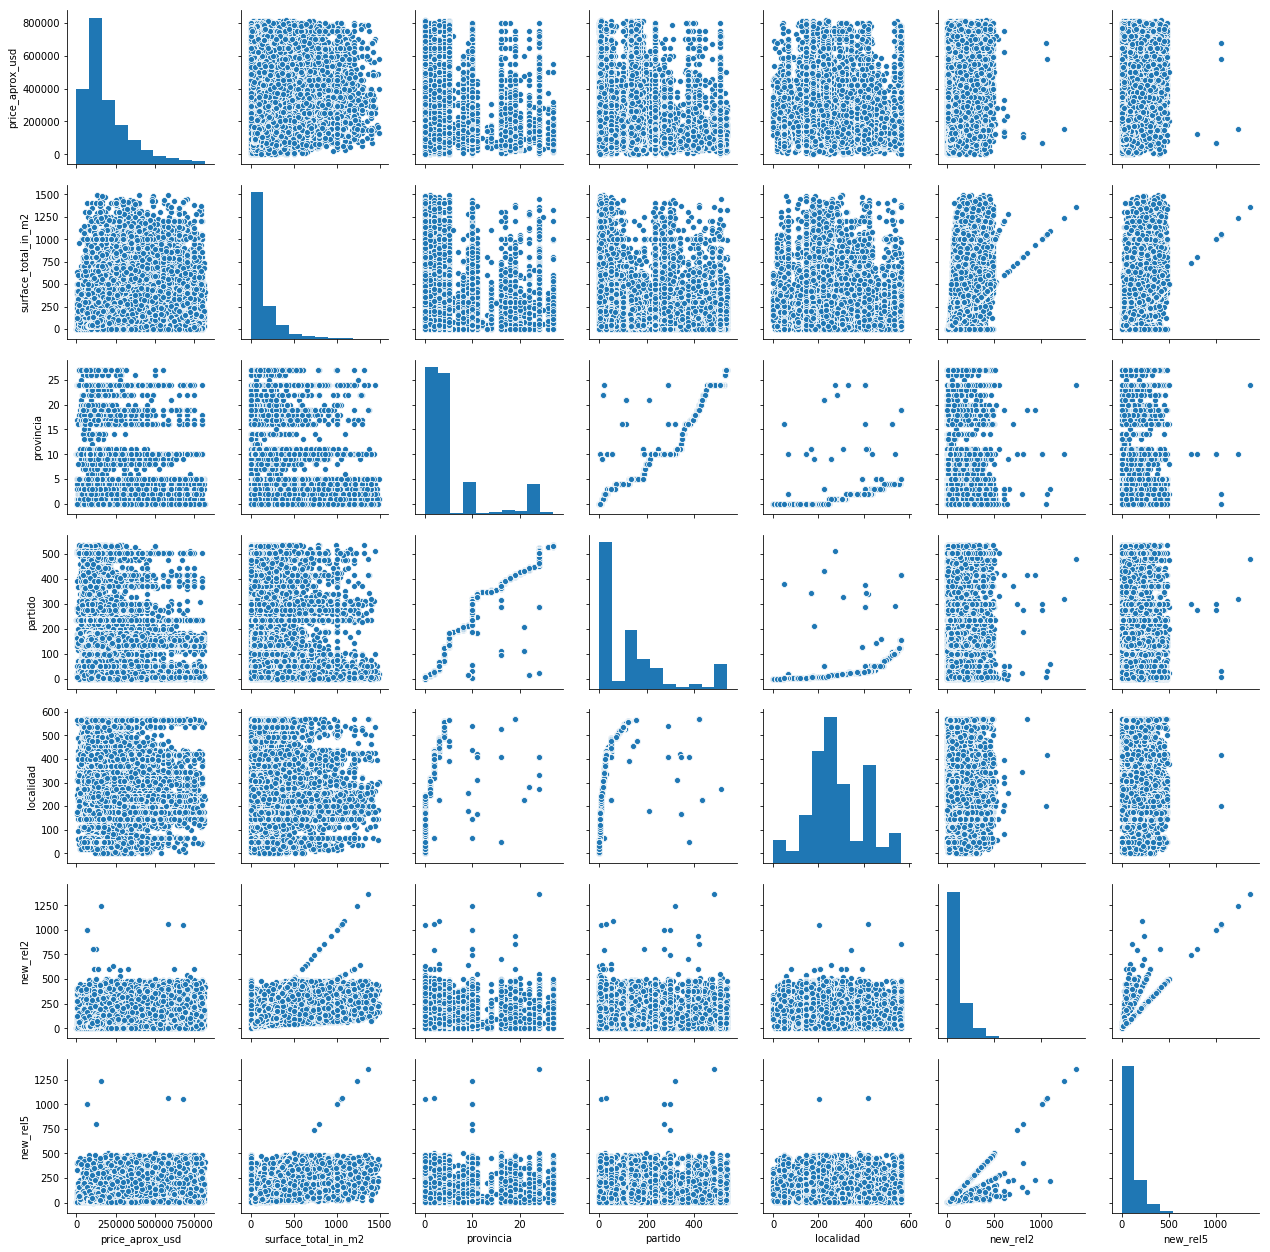

In [237]:
sns.pairplot(df)

In [281]:
# Agrupamos los datos por provincia
###Crear dummies para las siguientes categoricas
#### *provincia
#### *partido
#### *localidad --> eliminada

#Provincia
# df = pd.concat([df, pd.get_dummies(data = df['provincia'], prefix= 'dum_prov')], axis = 1)
#Localidad
df = pd.concat([df, pd.get_dummies(data = df['partido'], prefix= 'dum_part')], axis = 1)

In [282]:
#  Dropear columnas pasadas a dummies 
to_drop = [
            'provincia', 
            'partido', 
] 
df.drop(columns=to_drop, inplace=True) #aplicar drop
df.sample(1)

price_aprox_usd  surface_total_in_m2   new_rel2   new_rel5  \
80660         125000.0                 71.0  61.183333  60.591667   

       dum_part_0.0  dum_part_1.0  dum_part_2.0  dum_part_3.0  dum_part_4.0  \
80660             0             0             0             0             0   

       dum_part_5.0       ...        dum_part_517.0  dum_part_520.0  \
80660             0       ...                     0               0   

       dum_part_523.0  dum_part_525.0  dum_part_528.0  dum_part_529.0  \
80660               0               0               0               0   

       dum_part_534.0  dum_part_535.0  dum_part_536.0  dum_part_538.0  
80660               0               0               0               0  

[1 rows x 391 columns]

In [283]:
X = df.drop(['price_aprox_usd','surface_total_in_m2','new_rel5'], axis = 1)
y = df['price_aprox_usd']

# Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)


In [287]:
# Regresion linear
lm = LinearRegression()

model = lm.fit(X_train, y_train)
predictions = lm.predict(X_train)
model_score = model.score(X_test, y_test)
print('Model Score: ',model_score)
#el score mejora al utilizar localidad vs provincia
# print ('Intercepto=', ' ', model.intercept_)
# print ('RM=', ' ', model.coef_)

Model Score:  0.5332065762403329


ValueError: x and y must be the same size

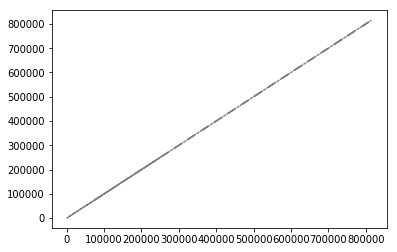

In [296]:
# Graficamos la variable X contra la variable Y
# plt.scatter([X_train], [y_train], s=30, c='r', marker='+', zorder=10)
# plt.xlabel("RM")
# plt.ylabel("Valores reales MEDV")
# plt.show()

# Graficamos el modelo
plt.plot(y_train,y_train, '-.',c='grey')
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones de MEDV usando RM")
plt.ylabel("Valores reales MEDV")
plt.show()